----------------------------------------------------------------
CARGA LIBRERÍAS Y DATOS

---------------------------------------------------------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency,f_oneway
from sklearn.preprocessing import OrdinalEncoder,PowerTransformer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from statsmodels.tools.tools import add_constant

Mounted at /content/drive


In [ ]:
#------------------------------------------------------
#Este archivo ya parte con:
# - nombres de las columnas cambiados
# - imputación de valores nulos con mediana y moda
# - formato de los datos correcto
#------------------------------------------------------

df = pd.read_csv("/content/drive/MyDrive/Cupido_IA_project/df_min_preprocesado_2.csv")

In [ ]:
df.describe()

,edad,sexo,tipo_dolor_pecho,tension_en_descanso,colesterol,azucar,electro_en_descanso,latidos_por_minuto,dolor_pecho_con_ejercicio,cambio_linea_corazon_ejercicio,forma_linea_corazon_ejercicio,num_venas_grandes,estado_corazon_thal,label
count,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000
mean,53.364754,0.789617,3.250000,131.848361,200.617486,0.153005,0.602459,138.244536,0.363388,0.855738,1.852459,0.239071,6.092896,1.132514
std,9.306868,0.407859,0.923363,18.582024,109.391407,0.360239,0.802966,25.173848,0.481304,1.079232,0.512585,0.646111,1.631463,1.257615
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,0.000000,3.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,177.750000,0.000000,0.000000,120.000000,0.000000,0.000000,2.000000,0.000000,6.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,223.000000,0.000000,0.000000,140.000000,0.000000,0.500000,2.000000,0.000000,7.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,267.000000,0.000000,1.000000,157.000000,1.000000,1.500000,2.000000,0.000000,7.000000,2.000000
max,76.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


-----------------------------------------------------

DESCRIPCIÓN GRÁFICA DE TODAS LAS VARIABLES

----------------------------------------------------

In [ ]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

n = len(num_cols)
n_cols = 3
n_rows = math.ceil(n / n_cols)

# Crear figura con subplots
fig = make_subplots(rows=n_rows, cols=n_cols,
                    subplot_titles=num_cols)

# Añadir cada histograma
for i, c in enumerate(num_cols):
    row = (i // n_cols) + 1
    col = (i % n_cols) + 1
    fig.add_trace(
        go.Histogram(x=df[c], nbinsx=30, name=c, showlegend=False),
        row=row, col=col)

# Ajustes finales
fig.update_layout(
    height=300*n_rows,
    width=400*n_cols,
    title_text="Distribución de variables",)

fig.show()

### ANÁLISIS UNIVARIANTE VARIABLES CUANTITATIVAS

--------------------------------------------------------------------------------
TEST DE NORMALIDAD

--------------------------------------------------------------------------------

In [ ]:
cols_continuas = ["edad",
    "tension_en_descanso",
    "colesterol",
    "latidos_por_minuto",
    "cambio_linea_corazon_ejercicio"]

resultados = []

for col in cols_continuas:
    serie = df[col].dropna()

    stat, p = stats.shapiro(serie)

    resultados.append({
        "variable": col,
        "statistic": stat,
        "p_value": round(p,5)})

pd.DataFrame(resultados)

#Las variables no siguen una distribuciones normales en el sentido estricto
#Posiblemente las colas o la asimetría siguen siendo determinantes

,variable,statistic,p_value
0,edad,0.990391,0.00010
1,tension_en_descanso,0.942852,0.00000
2,colesterol,0.865158,0.00000
3,latidos_por_minuto,0.991272,0.00025
4,cambio_linea_corazon_ejercicio,0.849860,0.00000


--------------------------------------
TESTS DE ASIMETRÍA Y COLAS

-------------------------------------

In [ ]:
asimetria = df[cols_continuas].skew(numeric_only=True)
curtosis = df[cols_continuas].kurtosis(numeric_only=True)

display(asimetria.sort_values(ascending=False).to_frame(name="Valor de Asimetría"))
display(curtosis.sort_values(ascending=False).to_frame(name="Valor de Curtosis"))

#Cambio_linea_corazon presenta sesgo alto positivo
#Tension_en_descanso con colas pesadas(presencia significativa de outliers)
#Candidatos a transformaciones para hacerlas mas gaussianas = menos complejidad para modelar

,Valor de Asimetría
cambio_linea_corazon_ejercicio,1.144441
tension_en_descanso,0.197323
edad,-0.203674
latidos_por_minuto,-0.234418
colesterol,-0.601473


,Valor de Curtosis
tension_en_descanso,3.814190
cambio_linea_corazon_ejercicio,1.589629
colesterol,0.267819
latidos_por_minuto,-0.315467
edad,-0.404528


----------------------------------------------------------------------
CONCLUSIONES PARCIALES ANÁLISIS UNIVARIANTE VARIABLES CUANTITATIVAS (bajo este contexto):

  - Preservación de tendencia central y por tanto concentración artificial con la imputación de mediana.

  - Ninguna variable sigue normalidad estrictamente

  - `Cambio_linea_corazon_ejercicio` y `tension_en_descanso` candidatas a transformación por sesgo y presencia de outliers, el resto de variables tienen un comportamietno más estable

---------------------------------------------------------------------


### ANÁLISIS UNIVARIANTE VARIABLES CATEGÓRICAS

------------------------------
INSPECCIÓN DE FRECUENCIAS  

--------------------------

In [ ]:
cat_cols = ["sexo",
    "tipo_dolor_pecho",
    "azucar",
    "electro_en_descanso",
    "dolor_pecho_con_ejercicio",
    "forma_linea_corazon_ejercicio",
    "estado_corazon_thal",
    "num_venas_grandes",
    "label"]

summary_list = []

for col in cat_cols:
    counts = df[col].value_counts(normalize=True) * 100
    top_cat = counts.idxmax()
    top_prop = counts.max()

    try:
        cat_fmt = int(top_cat)
    except:
        cat_fmt = top_cat

    prop_fmt = int(round(top_prop))
    dist_str = " | ".join([f"{int(idx) if isinstance(idx, float) and idx.is_integer() else idx} = {val:.1f}%" for idx, val in counts.items()])

    summary_list.append({
        "Variable": col,
        "Cat. Dominante": cat_fmt,
        "Dominancia (%)": prop_fmt,
        "Distribución Completa": dist_str})

df_summary = pd.DataFrame(summary_list)
display(df_summary.set_index("Variable").style.set_properties(**{'text-align': 'left'}))

,Cat. Dominante,Dominancia (%),Distribución Completa
Variable,,,
sexo,1,79,1 = 79.0% | 0 = 21.0%
tipo_dolor_pecho,4,53,4 = 53.4% | 3 = 23.0% | 2 = 18.9% | 1 = 4.8%
azucar,0,85,0 = 84.7% | 1 = 15.3%
electro_en_descanso,0,60,0 = 60.0% | 2 = 20.2% | 1 = 19.8%
dolor_pecho_con_ejercicio,0,64,0 = 63.7% | 1 = 36.3%
forma_linea_corazon_ejercicio,2,72,2 = 71.6% | 1 = 21.6% | 3 = 6.8%
estado_corazon_thal,7,74,7 = 73.6% | 3 = 21.4% | 6 = 4.9%
num_venas_grandes,0,86,0 = 85.5% | 1 = 7.4% | 2 = 4.8% | 3 = 2.3%
label,0,45,0 = 44.7% | 1 = 21.3% | 2 = 14.8% | 3 = 14.6% | 4 = 4.6%


--------------------------------------------------------------------
CONCLUSIONES PARCIALES ANÁLISIS UNIVARIANTE VARIABLES CATEGÓRICAS (bajo este contexto):

  - Preservación de tendencia cental y por tanto concentración artificial con un valor "único" con la imputación de moda sobre la clase dominante.

  - Se observa desbalance de clases agudo:
    - Sesgo hacia hombres en los datos
    - Representación en clases 1-2-3 moderada y marginal en clase 4 en variable target label (estratificar en splits)
     - Variables predictoras con clases <5% de proporción (reagrupación posible):
          - clase 1 tipo dolor pecho
          - clase 6 estado corazon thal
          - clase 3 num_venas_grandes
   - Variables casi constantes: azucar y num_venas grandes (candidatas a eliminación si no tienen correlación fuerte con label)

---------------------------------------------------------------------

### ÁNALISIS MULTIVARIANTE VARIABLES CUANTITATIVAS


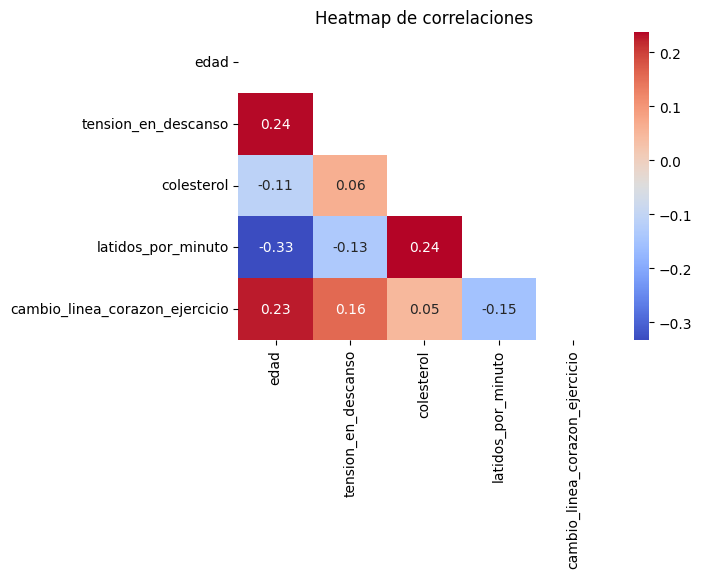

In [ ]:
# MATRIZ DE CORRELACIONES VARIABLES CUANTITATIVAS

df_cont = df[cols_continuas]
corr_matrix = df_cont.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(6,4))

sns.heatmap(corr_matrix,
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            mask=mask)

plt.title("Heatmap de correlaciones")
plt.show()


#No parece que haya relación lineal significativa entre pares (una vs una)

In [ ]:
#---------------------------------------------------------------------------
# Código corregido
# Por defecto, statsmodels asume una regresión que pasa por el origen (0,0).
# Al tener variables con magnitudes alejadas de cero (como edad o latidos),
# esto genera un falso positivo de multicolinealidad (VIF inflado) porque el
# modelo confunde la magnitud de los datos con su correlación.
# Se añade una constante (bias) para centrar la regresión y medir la
# colinealidad real (varianza compartida) y no la distancia al cero.
#------------------------------------------------------------------------

X_con_constante = add_constant(df_cont)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_con_constante.columns
vif_data["VIF"] = [variance_inflation_factor(X_con_constante.values, i) for i in range(X_con_constante.shape[1])]

# Eliminamos la fila de la constante ('const') para ver solo las variables
print(vif_data[vif_data["Variable"] != "const"])

#No parece que haya relación lineal entre todas las combinaciones (una vs todas)
#Se descarta que existan problemas de multicolinealidad -> todas las variables parecen ser relevantes

                         Variable       VIF
1                            edad  1.210756
2             tension_en_descanso  1.085393
3                      colesterol  1.082004
4              latidos_por_minuto  1.197606
5  cambio_linea_corazon_ejercicio  1.080650


In [ ]:
resultados_anova = []

#definir target
target = "label"

for col in cols_continuas:
    groups = [
        df[col][df[target] == level]
        for level in df[target].unique()]
    f_statistic, p_value = f_oneway(*groups)

    resultados_anova.append({
        "variable": col,
        "f_statistic": round(f_statistic, 4),
        "p_value": round(p_value, 4)})

df_anova = pd.DataFrame(resultados_anova)
print("Resultados ANOVA:")
print("Poder predictivo (p-value < 0.05 indica medias diferentes, es decir, significancia estadística):")
display(df_anova.sort_values(by="f_statistic", ascending=False))

# Las diferencias entre grupos entre todas las variables no se pueden descartar que tengan significancia (no son al azar)
# Sin embargo, el grado en las diferencias de los grupos entre variables es distinto:
#   - Las variables de corazon son las que más se diferencian entre clases
#   - Edad y colesterol también detectan diferencias pero puede que no sean tan amplias entre ciertos grupos
#   - Tension indica que existen diferencias entre grupos, pero posiblemente las menos elevadas

Resultados ANOVA:
Poder predictivo (p-value < 0.05 indica medias diferentes, es decir, significancia estadística):


,variable,f_statistic,p_value
4,cambio_linea_corazon_ejercicio,48.6424,0.0000
3,latidos_por_minuto,37.4247,0.0000
0,edad,18.0988,0.0000
2,colesterol,12.3018,0.0000
1,tension_en_descanso,4.2300,0.0022


### ANÁLISIS MULTIVARIANTE VARIABLES CATEGÓRICAS

In [ ]:
cat_cols = ["sexo",
    "tipo_dolor_pecho",
    "azucar",
    "electro_en_descanso",
    "dolor_pecho_con_ejercicio",
    "forma_linea_corazon_ejercicio",
    "estado_corazon_thal",
    "num_venas_grandes"]

def cramers_v(x, y):
    cont = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(cont)
    n = cont.sum().sum()
    phi2 = chi2 / n
    r, k = cont.shape

    # Corrección de bias
    phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)

    denom = min((k_corr-1), (r_corr-1))
    if denom <= 0:
        return 0.0
    return np.sqrt(phi2_corr / denom)


mat = pd.DataFrame(np.zeros((len(cat_cols), len(cat_cols))),
                   index=cat_cols, columns=cat_cols)

# Calcular valores
for c1 in cat_cols:
    for c2 in cat_cols:
        mat.loc[c1, c2] = cramers_v(df[c1], df[c2])


mask = np.triu(np.ones_like(mat, dtype=bool), k=1)
mat_masked = mat.mask(mask)

fig = px.imshow(mat_masked,
                text_auto=".2f",
                color_continuous_scale="RdBu_r",
                aspect="auto")

fig.update_layout(
    title="Matriz de Cramér’s V",
    plot_bgcolor='rgba(0,0,0,0)')
fig.show()

# Aunque no parece que haya problemas de multicolinealidad severa (relación lineal entre pares de variables fuerte):
#     - dolor_pecho + tipo_dolor_pecho tienen correlación moderada -> candidatas a feature engineering por posible redundancia
#     - estado_corazon tal + sexo/forma_linea_corazon y nº venas grandes + electro son asociaciones moderadas-débiles

In [ ]:
resultados_chi2 = []

for col in cat_cols:
    tabla = pd.crosstab(df[col], df[target])
    chi2, p, dof, expected = chi2_contingency(tabla)

    resultados_chi2.append({
        "variable": col,
        "chi2": round(chi2,2),
        "p_value": round(p,2),
        "df": dof})

df_chi2 = pd.DataFrame(resultados_chi2)
df_chi2 = df_chi2.sort_values("chi2", ascending=False);df_chi2

# Las diferencias entre las proporciones por variable agrupadas según la variable label demuestran que no son al azar (p-value <0.05)
#   - Excepto electro en descanso que parece que sus proporciones pueden ser aleatorias (seria candidata a ser eliminada)
# El x^2 indica la capacidad de discriminar las clases según la variable, por lo que:
#   - Las variables relacionadas con el pecho parecen ser las más determinantes
#   - Las variables de sexo, estado corazon, nº de venas grandes y froma linea corazon parecen ser factores de riesgo
#   - Las variables de azucar y electro en descanso parecen ser las menos relevantes

# Aunque tenga sensibilidad el x^2 al desbalance de clases y nº de categorías por variable, se aceptan los resultados por las grandes diferencias entre variables


,variable,chi2,p_value,df
1,tipo_dolor_pecho,194.79,0.00,12
4,dolor_pecho_con_ejercicio,133.94,0.00,4
0,sexo,72.06,0.00,4
6,estado_corazon_thal,67.13,0.00,8
5,forma_linea_corazon_ejercicio,48.15,0.00,8
7,num_venas_grandes,42.90,0.00,12
3,electro_en_descanso,14.87,0.06,8
2,azucar,14.51,0.01,4


In [ ]:
results = []

for col in cat_cols:
    score = cramers_v(df[col], df[target])
    results.append({
        "Variable": col,
        "Asociación con Target (V Cramér)": score})

#[0,1] -> 0 = asociación nula - 1 = asociación intensa
df_predictivo = pd.DataFrame(results).sort_values(by="Asociación con Target (V Cramér)", ascending=False)
display(df_predictivo.style.background_gradient(cmap="Greens", subset=["Asociación con Target (V Cramér)"]).format({"Asociación con Target (V Cramér)": "{:.2f}"}))

# Dolor pecho ejercicio parece ser el que mayor relación tiene con label en comparación con el resto
# Sexo (posibilidad de modelos distintos) y tipo dolor parecen tener relación moderada también
# Nº de venas grandes (a profundizar) + electro + azucar -> candidatas a eliminación por relación marginal/casi nula

,Variable,Asociación con Target (V Cramér)
4,dolor_pecho_con_ejercicio,0.42
0,sexo,0.31
1,tipo_dolor_pecho,0.29
6,estado_corazon_thal,0.20
5,forma_linea_corazon_ejercicio,0.17
2,azucar,0.12
7,num_venas_grandes,0.12
3,electro_en_descanso,0.07


# 📊 Conclusiones generales

---

### 1. 🛠️ Estrategia de Calidad y Transformación
* **Imputación:** Se ha priorizado la preservación de la tendencia central mediante **mediana** (numéricas) y **moda** (categóricas).
    * *Comprosmiso:* Se asume una concentración artificial de datos (varianza reducida) para evitar sesgos por nulos.
    * Las variables`num_venas_grandes` y `estado_corazon_thal` son las más afectadas por tener >20% nulos y se diluye información valiosa
* **Normalización:** Aunque ninguna variable es estrictamente gaussiana, solo hay dos variables candidtas a ser transformadas para suavizar eficazmente colas y asimetrías, para reducir la complejidad para el modelado.

---

### 2. ⚠️ Alertas Estructurales (Análisis Univariante)
* **Desbalance Crítico del Target:** La Clase 4 (Enfermedad grave) es marginal (**<5%**).
    * 👉 **Acción Obligatoria:** Split estratificado
* **Sesgo Demográfico:** Sobrerepresentación significativa del género masculino.
* **Categorías Raras (<5%):** Detectadas en `tipo_dolor` (clase 1), `thal` (clase 6) y `venas` (clase 3).
    * 👉 **Acción:** Riesgo de ruido/overfitting en estas particiones específicas.
* **Variables Cuasi-Constantes:** `azucar` y `num_venas_grandes` concentran gran masa en el valor 0.

---

### 3. 🔍 Jerarquía de Poder Predictivo (Análisis Multivariante)
*Se descarta multicolinealidad severa (VIF ≈ 1.0). Las variables son independientes. Test de ANOVA y de Cramer establecen jerarquías. Interpretación cautelosa con `num_venas_grandes`y `estado_corazon_thal` (sesgo por imputación). *

| Nivel de Importancia | Variables (Drivers) | Hallazgo Clave |
| :--- | :--- | :--- |
| **🥇 TIER 1 (Determinantes)** | `dolor_pecho_ejercicio`<br>`sexo`<br>`cambio_linea_ejercicio`<br>`latidos_por_minuto` | **Respuesta al Estrés:** Las variables que miden la reacción al esfuerzo físico (y el género) son los discriminadores más potentes (F-Stat y V-Cramér moderados). |
| **🥈 TIER 2 (Factores de Riesgo)** | `tipo_dolor_pecho`<br>`edad`<br>`colesterol`<br>`estado_thal` | Aportan información relevante pero con mayor solapamiento entre grupos. Definen el perfil de riesgo base. |
| **🥉 TIER 3 (Marginales/Ruido)** | `tension_en_descanso`<br>`azucar`<br>`electro_en_descanso` | **Estado Basal:** Relación estadística débil o casi nula. Son candidatas a eliminación. |

---

# 🧪 Estrategias de Optimización

Posibles estrategias de limpieza, ingeniería y modelado a validar empíricamente frente al *Baseline* actual en las futuras iteraciones

---

### 1. 🧹 Calidad del Dato: Imputación y Outliers
> *Recordatorio 2º iteración:* Se imputaron nulos con Mediana/Moda y se suavizaron distribuciones con transformaciones Box-Cox/Yeo-Johnson.

* **A. Estrategias de Imputación (Comparativa):**
    * **KNN Imputer:** Probar imputación basada en "vecinos más cercanos" para respetar la correlación estructural (ej. edad vs latidos) en lugar de un valor fijo central.
    * **Imputación por Dominio:** Verificar si los nulos en `thal` o `venas` son realmente ceros o siguen algun patrón (MNAR)
* **B. Gestión de Outliers:**
    * **Trimming Estricto:** Probar la eliminación física de registros con Z-Score > 3 en variables críticas (Colesterol, Tensión) para limpiar la frontera de decisión, o eliminación manual según información.

---

### 2. 🧬 Feature Engineering: Dominio + No Supervisado
> *Recordatorio 2º iteración:* Se encuentra la variable sintética `porcentaje_max_hr`(falta crearla y añadirla)

* **A. Conocimiento Médico (Explicit Features):**
    * **Interacciones de Riesgo:** Crear `perfil_angina` cruzando `tipo_dolor` × `dolor_con_ejercicio`.
    * **Binning (Discretización):** Convertir `edad` en grupos de riesgo (`Joven`, `Adulto`, `Senior`) para capturar saltos no lineales de riesgo.
    * **Flags de Anomalía:** Variable binaria si (Tensión > X OR Colesterol > Y).
* **B. Aprendizaje de Variedades (Latent Features):**
    * **UMAP + Clustering:** Proyectar datos a 2D/3D con UMAP y aplicar DBSCAN/GMM para encontrar subgrupos de pacientes. Usar el `Cluster_ID` resultante como nueva variable predictora (Meta-feature).

---

### 3. 🔍 Selección de Características (Filtrado)
> *Recordatorio 2º iteración:* Se descartó multicolinealidad con VIF y se jerarquizaron variables por ANOVA/Cramér.

* **A. Candidatas a Eliminación:**
    * Entrenar una versión del modelo **sin** `electro_en_descanso` ni `azucar` (señal ruido detectada en EDA) para validar si mejora la generalización.
* **B. Selección Automática:**
    * **Lasso (L1):** Usar regularización fuerte para forzar coeficientes a cero y seleccionar variables automáticamente.
    * **Tree-based Importance:** Usar Random Forest para detectar variables no lineales que el ANOVA pudo subestimar.

---

### 4. ⚖️ Gestión del Desbalance (Clase 4 < 5%)
> *Recordatorio 2º iteración:* Se aplicó muestreo estratificado estándar con SMOTE (vecinos sintéticos interpolados linealmente)

* **A. Generación de Datos Sintéticos (Oversampling):**
    * **ADASYN:** Similar a SMOTE, pero generando más datos en las zonas "difíciles" de la frontera de decisión.
* **B. Aprendizaje Sensible al Coste:**
    * **Class Weights:** No generar datos nuevos, sino penalizar algorítmicamente el error en la Clase 4 (`class_weight='balanced'`). Posible omisión,
* **C. Cross validatiom:**
    * Evaluar la estabilidad de los modelos y evitar el sesgo de un split afortunado (si se hace con SMOTE/ADASYN, hay que ejecutar esa técnica en cada fold)

---

### 5. 🏗️ Arquitecturas de Modelado Avanzadas
> *Recordatorio 2º iteración:* Comparativa estándar de modelos multiclase directos.

* **A. Ensamble:**
    * *Etapa 1:* Modelo Binario (Sano vs. Enfermo).
    * *Etapa 2:* Modelo Multiclase (Grados 1-4) entrenado solo con enfermos.
* **B. Regresión Ordinal:**
    * Tratar el target como continuo y usar regresores (XGBoost/LGBM) con **Optimized Thresholds** (cortes personalizados) en lugar de clasificación pura, aprovechando el orden de la severidad.

In [ ]:
#Descargo el df usado
#Al archivo incial, hay que añadirle las transformaciones hechas a las variables cuantitativas

import os
df.to_csv('/content/drive/MyDrive/df_filtrado_preprocesado_3.csv', index=False)